In [23]:
from torchvision.datasets import FashionMNIST as fm
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


data_root = './torchvision/data'

img_transform = transforms.Compose([
    transforms.ToTensor()
])
fm_train = fm(root = data_root, train = True, download = False, transform = img_transform)


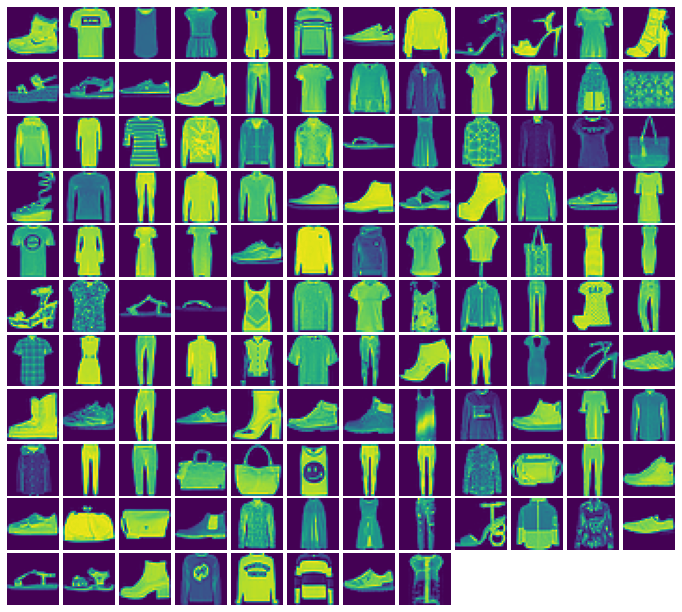

In [24]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

class ChunkSampler(sampler.Sampler): 
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
batch_size = 128
loader_train = DataLoader(fm_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()

show_images(imgs)

In [41]:
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.nn as nn
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np

def to_img(x):
    out = 0.5 * (x + 1)
    out = out.clamp(0, 1)
    out = out.view(-1, 1, 28, 28)
    return out

def max_min(dataset):
  dataset = dataset.detach().numpy()
  dataset = [(i/9) for i in dataset]
  dataset = torch.Tensor(dataset)
  return dataset

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ##### 定义判别器 Discriminator######
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2), 
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        x = self.dis(x)
        return x
 
# ###### 定义生成器 Generator #####
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x

batch_size = 512
num_epoch = 150
z_dimension = 100

D = discriminator().to(device)
G = generator().to(device)
 
criterion = nn.BCELoss().to(device)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

# ##########################进入训练##判别器的判断过程#####################
for epoch in range(num_epoch):
  for i, (img, _) in enumerate(loader_train):
    num_img = img.size(0)
    img = img.view(num_img, -1).to(device)
    real_img = Variable(img)
    real_label = Variable(torch.ones(num_img)).to(device)
    fake_label = Variable(torch.zeros(num_img)).to(device)

    # ==================训练生成器============================
    z = Variable(torch.randn(num_img, z_dimension).to(device))
    fake_img = G(z)
    output = D(fake_img)
    output = output.squeeze()

    g_loss = criterion(output, real_label)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # ==================训练判别器============================
    real_out = D(real_img)
    real_out = real_out.squeeze()
    d_loss_real = criterion(real_out, real_label)
    real_scores = real_out

    # z = Variable(torch.randn(num_img, z_dimension).to(device))
    fake_img = G(z).detach()
    fake_out = D(fake_img)
    fake_out = fake_out.squeeze()
    d_loss_fake = criterion(fake_out, fake_label)
    fake_scores = fake_out

    d_loss = (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

  print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
        'D real: {:.6f},D fake: {:.6f}'.format(
      epoch, num_epoch, d_loss.data.item(), g_loss.data.item(),
      real_scores.data.mean(), fake_scores.data.mean()
  ))

Epoch[0/150],d_loss:3.784093,g_loss:0.112705 D real: 0.657135,D fake: 0.943475
Epoch[1/150],d_loss:1.834938,g_loss:0.221279 D real: 0.894968,D fake: 0.818173
Epoch[2/150],d_loss:0.213679,g_loss:2.561885 D real: 0.923468,D fake: 0.110068
Epoch[3/150],d_loss:1.013642,g_loss:1.321533 D real: 0.599946,D fake: 0.310492
Epoch[4/150],d_loss:0.717176,g_loss:1.477438 D real: 0.766233,D fake: 0.283028
Epoch[5/150],d_loss:0.881115,g_loss:1.511453 D real: 0.628951,D fake: 0.215262
Epoch[6/150],d_loss:0.389585,g_loss:2.978476 D real: 0.866988,D fake: 0.072837
Epoch[7/150],d_loss:1.056305,g_loss:0.874227 D real: 0.643396,D fake: 0.427649
Epoch[8/150],d_loss:0.266846,g_loss:2.760804 D real: 0.880627,D fake: 0.118757
Epoch[9/150],d_loss:0.204991,g_loss:2.931257 D real: 0.930462,D fake: 0.073392
Epoch[10/150],d_loss:0.770946,g_loss:1.793612 D real: 0.664729,D fake: 0.239672
Epoch[11/150],d_loss:1.503417,g_loss:2.230912 D real: 0.586030,D fake: 0.304635
Epoch[12/150],d_loss:0.563766,g_loss:2.314746 D re

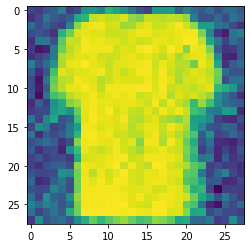

In [56]:
z_test = torch.randn(64, 100).to(device)
z_img = G(z_test)
z_img = z_img.view(z_img.size(0), 28, 28)

z_sample = to_img(z_img[0].cpu().data).squeeze()
plt.imshow(z_sample) 